# Deadpool-Sentiment-Analysis

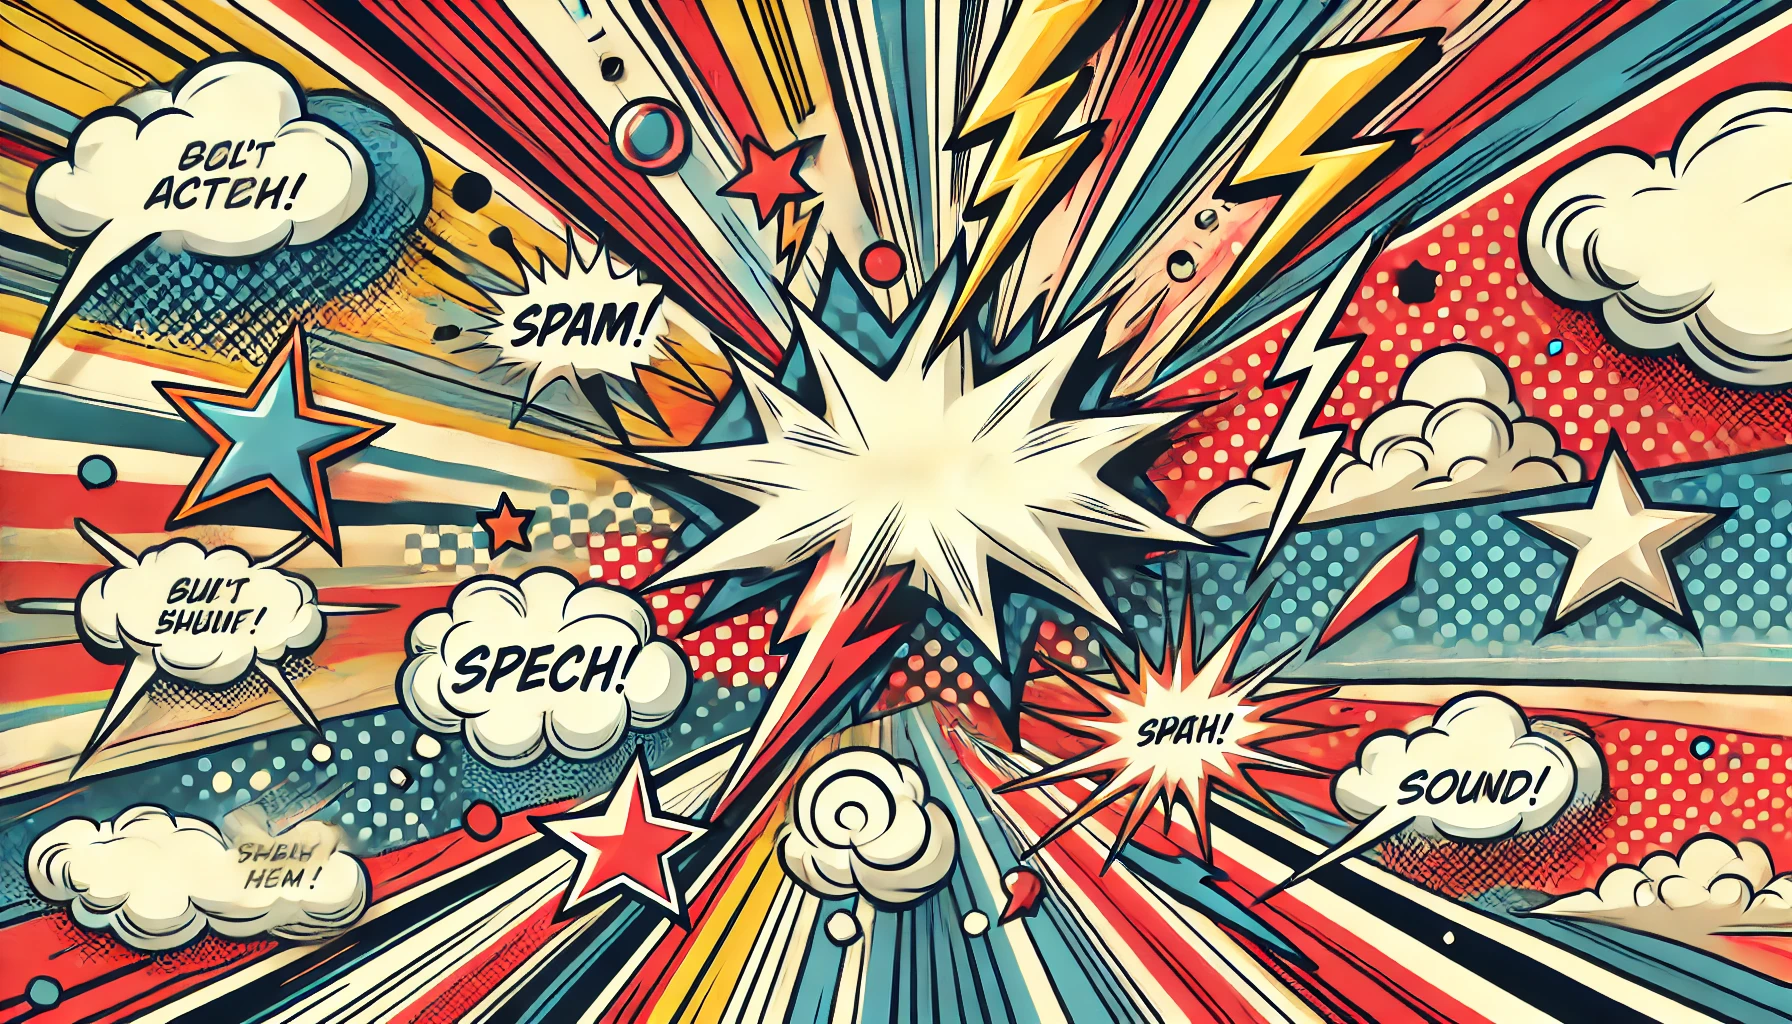

You want to decide whether to watch the new Deadpool movie in the cinema, but you don't want to read through all the reviews because you fear they might spoil the best scenes. You know that YouTube now generates automatic captions for almost all videos, which are of quite good quality and available via API. You've figured that if you can download these captions, you could run a sentiment analysis on them to find out what your favorite YouTubers think about the new film. Should you go to the cinema, or wait until it's available for home viewing?

During this task, download the subtitles for the specified 8 videos, then run a sentiment analysis pipeline on them using the provided tips.

In [1]:
%%capture
pip install youtube-transcript-api

In [2]:
from youtube_transcript_api import YouTubeTranscriptApi

# Function to download transcripts
def get_transcript(video_id):
    transcript = YouTubeTranscriptApi.get_transcript(video_id)
    combined_text = " ".join([entry['text'] for entry in transcript])
    return combined_text

# List of YouTube video IDs
video_ids = [
    "JTyZeMPOP18",
    "z0Ntsk-i4ks",
    "hjesFmiKOOY",
    "5H2s7nkDugo",
    "IjGLRKhDDnA",
    "l_n-Cw_whls",
    "DLquU1VZkBA",
    "myKMOgTzins",
]

# Download transcripts for all videos
combined_texts = [get_transcript(video_id) for video_id in video_ids]


In [3]:
from transformers import pipeline, AutoTokenizer

# Initialize tokenizer and sentiment analysis pipeline
tokenizer = AutoTokenizer.from_pretrained('lvwerra/distilbert-imdb')
sentiment_pipeline = pipeline("sentiment-analysis", model='lvwerra/distilbert-imdb', tokenizer=tokenizer)

# Function to split text into chunks based on token length
def split_text_into_chunks(text, max_length=500):
    words = text.split()
    chunks = []
    current_chunk = []

    for word in words:
        current_chunk.append(word)
        current_text = ' '.join(current_chunk)
        current_length = len(tokenizer.tokenize(current_text))
        if current_length > max_length:
            # Remove last word and add the chunk
            current_chunk.pop()
            chunk_text = ' '.join(current_chunk)
            chunks.append(chunk_text)
            current_chunk = [word]
    if current_chunk:
        chunk_text = ' '.join(current_chunk)
        chunks.append(chunk_text)
    return chunks

# Function to analyze sentiment for long text
def analyze_sentiment_for_long_text(long_text):
    chunks = split_text_into_chunks(long_text)
    positive_score, negative_score, neutral_score = 0.0, 0.0, 0.0

    for chunk in chunks:
        result = sentiment_pipeline(chunk)
        for res in result:
            if res['label'] == 'POSITIVE':
                positive_score += res['score']
            elif res['label'] == 'NEGATIVE':
                negative_score += res['score']
            elif res['label'] == 'NEUTRAL':
                neutral_score += res['score']

    if positive_score > negative_score and positive_score > neutral_score:
        return 'POSITIVE'
    elif negative_score > positive_score and negative_score > neutral_score:
        return 'NEGATIVE'
    else:
        return 'MIXED/NEUTRAL'

# Analyze sentiments for each video
video_sentiments = []
for idx, text in enumerate(combined_texts):
    sentiment = analyze_sentiment_for_long_text(text)
    video_sentiments.append(sentiment)
    print(f"Video {idx+1} sentiment: {sentiment}")

# Determine the majority sentiment among YouTubers
from collections import Counter
sentiment_counts = Counter(video_sentiments)
majority_sentiment = sentiment_counts.most_common(1)[0][0]
print(f"\nThe majority sentiment is: {majority_sentiment}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Video 1 sentiment: POSITIVE
Video 2 sentiment: POSITIVE
Video 3 sentiment: POSITIVE
Video 4 sentiment: POSITIVE
Video 5 sentiment: NEGATIVE
Video 6 sentiment: NEGATIVE
Video 7 sentiment: POSITIVE
Video 8 sentiment: POSITIVE

The majority sentiment is: POSITIVE
